In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)
import tqdm

Sigmoid neurons

In [84]:
d = 100 # dimension of space
M = 20 # number of neurons for generation

In [85]:
def sigma(x):
    return (1. / (1. + np.exp(-x)))

In [86]:
class Neuron:
    def __init__(self):
        self.a = np.random.normal(loc = 2., scale = 10.)
        self.w = np.random.normal(size = d)
        self.b = np.random.normal()
    def set_weights(self, a, w, b):
        self.a = a
        self.w = w
        self.b = b
    def forward(self, x):
        return self.a * sigma(self.w.dot(x) + self.b)

In [87]:
class Network:
    def __init__(self, width):
        self.width = width
        self.neurons = [Neuron() for i in range(width)]
    def zero_out(self):
        for nr in self.neurons:
            nr.set_weights(0., nr.w, nr.b)
    def zero_bias(self):
        for nr in self.neurons:
            nr.set_weights(nr.a, nr.w, 0)
    def output(self, x):
        return np.mean([n.forward(x) for n in self.neurons])
    def loss(self, x, y):
        return .5*(self.output(x) - y)**2
    def grad(self, x, y):
        d = (self.output(x) - y)
        s = np.array([sigma(n.w.dot(x) + n.b) for n in self.neurons])
        ga = 1./self.width * d * s
        gb = 1./self.width * d * np.array([self.neurons[i].a*s[i]*(1-s[i]) for i in range(self.width)])
        gw = np.array([gb[i] * x for i in range(self.width)]) # shape m * d
        return ga, gw, gb
    def step(self, x, y, tau):
        ga, gw, gb = self.grad(x, y)
        for i in range(self.width):
            nr = self.neurons[i]
            a_new = nr.a - tau * ga[i]
            w_new = nr.w - tau * gw[i]
            b_new = nr.b - tau * gb[i]
            nr.set_weights(a_new, w_new, b_new)
    def batch_step(self, X, Y, tau):
        ba = X.shape[0]
        Ga, Gw, Gb = np.zeros((ba, self.width)), np.zeros((ba, self.width, d)), np.zeros((ba, self.width))
        for i in range(ba):
            Ga[i], Gw[i], Gb[i] = self.grad(X[i], Y[i])
        ga, gw, gb = Ga.sum(axis = 0), Gw.sum(axis = 0), Gb.sum(axis = 0)
        for i in range(self.width):
            nr = self.neurons[i]
            a_new = nr.a - tau * ga[i]
            w_new = nr.w - tau * gw[i]
            b_new = nr.b - tau * gb[i]
            nr.set_weights(a_new, w_new, b_new)
    def sgd_train(self, X, Y, tau, epochs, batch, disp = True):
        for e in range(epochs):
            pm = np.random.permutation(X.shape[0])
            X = np.array([X[pm[i]] for i in range(X.shape[0])])
            Y = np.array([Y[pm[i]] for i in range(Y.shape[0])])
            if batch > 1:
                nbatch = X.shape[0]//batch
                subX = np.split(X, nbatch)
                subY = np.split(Y, nbatch)
                for s in range(len(subX)):
                    self.batch_step(subX[s], subY[s], tau)
            else:
                for i in range(X.shape[0]):
                    self.step(X[i], Y[i], tau)
            loss = self.test(X, Y)
            if disp:
                print('epoch '+str(e)+' : '+str(loss))
        return loss
    def test(self, X_t, Y_t):
        ts = X_t.shape[0]
        return np.mean([self.loss(X_t[i], Y_t[i]) for i in range(ts)])
    def gen_sample(self, R, s = 1):
        if s==1:
            X = np.random.normal(size = d)
            # see one which one it should be
            #X = R * X / np.linalg.norm(X, 2)
            X = R * X / np.sqrt(1. + np.linalg.norm(X, 2)**2)
            Y = self.output(X)
            return X, Y
        else:
            X = np.random.normal(size = (s, d))
            Y = np.zeros(s)
            for i in range(s):
                # see one which one it should be
                X[i] = R * X[i] / np.sqrt(1. + np.linalg.norm(X[i], 2)**2)
                #X[i] = R* X[i] / np.linalg.norm(X[i], 2)
                Y[i] = self.output(X[i])
            return X, Y
    def give_weights(self):
        la, lw, lb = np.zeros(self.width), np.zeros((self.width, d)), np.zeros(self.width)
        for i in range(self.width):
            nr = self.neurons[i]
            la[i] = nr.a
            lw[i] = nr.w
            lb[i] = nr.b
        return la, lw, lb
    def display_weights(self, fig, ax, scatp = None, scatn = None, true_w = None, color='b'):
        assert d==2, 'must be in dimension 2'
        #ax.cla()
        ax.set_xlim((-3, 3))
        ax.set_ylim((-3, 3))
        la, lw, _ = self.give_weights()
        xp, yp, sp, xn, yn, sn = [],[],[],[],[],[]
        la = la / np.linalg.norm(la, 2)
        for k in range(self.width):
            if la[k] >=0:
                xp.append(lw[k, 0])
                yp.append(lw[k, 1])
                sp.append(500 * la[k])
            else:
                xn.append(lw[k, 0])
                yn.append(lw[k, 1])
                sn.append(-500 * la[k])
                
        if scatp is None:
            pos = ax.scatter(xp, yp, s = sp, color='r')
        else:
            scatp.set_sizes(30*sp)
            scatp.set_offsets(np.array([xp, yp]).T)
            trace = ax.scatter(xp, yp, s = 5., color='grey', alpha = 0.4)
            
        if scatn is None:
            neg = ax.scatter(xn, yn, s = sn, color='b')
        else:
            scatn.set_sizes(30*sn)
            scatn.set_offsets(np.array([xn, yn]).T)
            trace = ax.scatter(xn, yn, s = 5., color='grey', alpha = 0.4)
        
        if true_w is not None:
            tla, tlw, _ = true_w
            tx, ty = np.zeros(tla.shape[0]), np.zeros(tla.shape[0])
            for k in range(tla.shape[0]):
                tx[k] = tlw[k, 0]
                ty[k] = tlw[k, 1]
                u = np.linspace(-3, 3., 10)
                v = ty[k]/tx[k] * u
                ax.plot(u, v, color = 'k')
        
        if scatp is None and scatn is None:
            fig.canvas.draw()
        #del pos
        #del neg
        return xp, yp, xn, yn

In [127]:
#fig, ax = plt.subplots(figsize=(10, 6))

gen_net = Network(M)

true_w = gen_net.give_weights()
#xp, yp, xn, yn = gen_net.display_weights(fig, ax, color='g', true_w = true_w)
#ax.scatter(xp, yp, s = 10., color='r')
#ax.scatter(xn, yn, s = 10., color='b')

Initialize new network with first parameter 0 and others normal.

Data on the sphere

Train it using SGD

In [146]:
X_test, Y_test = gen_net.gen_sample(R = 1., s = 10000)

In [180]:
net = Network(50) # over-parametrized
net.zero_out()

test_loss = []
train_loss = []
for i in range(5000):
    X, Y = gen_net.gen_sample(R = 1., s = 100)
    net.sgd_train(X, Y, tau = 50., batch = 1, epochs = 1, disp = False)
    if i%10 == 0:
        test = net.test(X_test, Y_test)
        train = net.test(X, Y)
        test_loss.append(test)
        train_loss.append(train)
        print(test)

0.06077706696589289
0.006392231414209656
0.003529081746950808
0.0032251572319203048
0.0031999218435324332
0.002972221987279644
0.003157393794878625
0.002530154575687913
0.002440600224323427
0.0027187391160209016
0.0022880752994559523
0.0029225430066772335
0.002517523300273254
0.0021240482517673512
0.002082822549177759
0.0020632133550181923
0.002671328545359838
0.0053803802983848755
0.001913666963537464
0.0017681779929353077
0.0018602145672783922
0.0018709637182903385
0.002235475715271235
0.0016550621777388847
0.0016401962365436397
0.0017169768775446685
0.0016727546971110534
0.0014899116625012863
0.0015590701014631474
0.0015956646985994187
0.002004616057605516
0.0014744902271427499
0.0016264712828623076
0.0013069198610294926
0.0013911069454091958
0.0011626658160036026
0.0012291141597623226
0.0011967972313103345
0.0012579024145253997
0.001402860249123107
0.0010785984882262724
0.0011391292721905843
0.0011741908432726924
0.0010587448311709879
0.0013965594080192767
0.001052641836282252
0.00

KeyboardInterrupt: 

Text(0.5,1,'Training a neural network with 50 units (M = 20)')

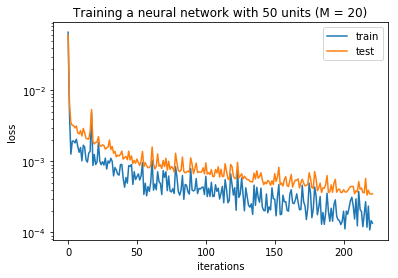

In [181]:
plt.figure()
plt.plot(train_loss)
plt.plot(test_loss)
plt.legend(['train', 'test'])
plt.xlabel('iterations')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Training a neural network with 50 units (M = 20)')

In [175]:
net = Network(3) # under-parametrized
net.zero_out()

test_loss = []
train_loss = []
for i in range(5000):
    X, Y = gen_net.gen_sample(R = 1., s = 100)
    net.sgd_train(X, Y, tau = 5., batch = 1, epochs = 1, disp = False)
    if i%10 == 0:
        test = net.test(X_test, Y_test)
        train = net.test(X, Y)
        test_loss.append(test)
        train_loss.append(train)
        print(test)

0.19549017230560886
0.010128777257667804
0.004568539966342107
0.00586353303481776
0.005010869907005907
0.0038236131179704394
0.003951977572949077
0.005666950013682372
0.006058434263862233
0.004735304170785865
0.004661535184068572
0.003935667527092133
0.0028212310204303362
0.0028790343478308986
0.0027839352105222923
0.004003042357417625
0.0027696671221119386
0.0035040214273110316
0.0034209557725229096
0.002665439749937502
0.0025562578523308584
0.002734601788236397
0.0024198196417274916
0.0029868201714834397
0.007601541900670065
0.002399797788702608
0.0027926127923358804
0.002922027807461272
0.0024497487880427355
0.0037631533369027856
0.0031286603632436362
0.002798586130734186
0.0026524994560379878
0.0027831929895604434
0.0025075694413690636
0.00239922855322315
0.002594353067498996
0.0025125911733883243
0.0026805217929108858
0.002467641933293392
0.0023618579672397455
0.0023628115767645925
0.0024587905882637916
0.003943186049628719
0.002935780227393951
0.002471579178782934
0.0040246105177

0.002034552319355855
0.002444675102754875
0.0021874856222802654
0.002170448842973202
0.002013456679146742
0.0026601549098530875
0.002539116199486543
0.0023626275069534497
0.002519804384540214
0.0024997504977246014
0.006801969270088584
0.002633176681875066
0.0029996174739919516
0.002011291786975321
0.0021691360905953124
0.002550592150387419
0.0021162205252735033
0.002034342722226146
0.0021626927871372112
0.0035361477219446984
0.005165665988729275
0.0035510653128944325
0.002430859853152801
0.00253858197688391
0.002078873338455467
0.00289969109877389
0.005247393024792039
0.0025239820202670638
0.002937269777124204
0.001979085464075336
0.002199999698703491
0.0030105142776028
0.002105147404383055
0.0022134034579940655
0.0021225727234815794
0.002031028185046129
0.0021457819107262395
0.0030709779369210884
0.0022432135854426457
0.002315366631389224
0.0021723106027762918
0.002606718561958216
0.0037737635849828793
0.003970837525787285
0.0023843047200189835
0.002136819838965284
0.00220310691548651

Text(0.5,1,'Training a neural network with 3 units (M = 20)')

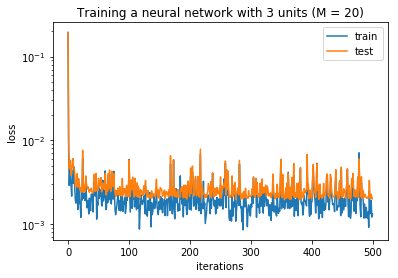

In [178]:
plt.figure()
plt.plot(train_loss)
plt.plot(test_loss)
plt.legend(['train', 'test'])
plt.xlabel('iterations')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Training a neural network with 3 units (M = 20)')

In [ ]:
net = Network(100) # sehr ober-parametrized
net.zero_out()

test_loss = []
train_loss = []
for i in range(5000):
    X, Y = gen_net.gen_sample(R = 1., s = 100)
    net.sgd_train(X, Y, tau = 100., batch = 1, epochs = 1, disp = False)
    if i%10 == 0:
        test = net.test(X_test, Y_test)
        train = net.test(X, Y)
        test_loss.append(test)
        train_loss.append(train)
        print(test)

0.062101753624403844
0.008358165385413549
0.0036457985565475646
0.0042470370420035625
0.0026093011020188153
0.0031882464913101523
0.002719421268067459
0.002855416971864845
0.00249070784756687
0.0022877201574254945
0.003218048889761603
0.0022877434571001915
0.0020332239021205725
0.0021366280405834713
0.001923198106732993
0.0020462177276512786
0.0018148533417875503
0.001837593724419498
0.0017027911706659405
0.0019557235142676176
0.0015480635756731614
0.001548070779077079
0.0015276653009253613
0.0014890849450357423
0.001375241717595457
0.0013748166420742575
0.0014135920677510844
0.0012727213429344576
0.0013254304738002914
0.0012326095945298752
0.0012486805625566803
0.0012729448203761908
0.0011725065486441933
0.0014299253041601882
0.0016924760956210456
0.0012473581891204442
0.0011545641476872642
0.0013867785546955807
0.0016158420612726622
0.0011193634286294652
0.0010778338718244402
0.0010286275554325691
0.0013612983392695447
0.0009907616526168325
0.0010279522535133598
0.0009614298686147712

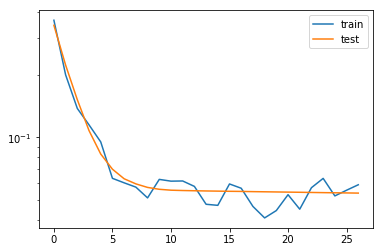

In [154]:
plt.figure()
plt.plot(train_loss)
plt.plot(test_loss)
plt.legend(['train', 'test'])
plt.xlabel('iterations')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Training a neural network with 100 units (M = 20)')

Learning rate: lr ~ nbr of neurons

We DO NOT reproduce the results :(

## Make several experiments for different values of $m$

In [58]:
np.logspace(0.6, 2.0, 15, base = 10.)

array([  3.98107171,   5.01187234,   6.30957344,   7.94328235,
        10.        ,  12.58925412,  15.84893192,  19.95262315,
        25.11886432,  31.6227766 ,  39.81071706,  50.11872336,
        63.09573445,  79.43282347, 100.        ])

Early stopping if no improvement for k rounds -> def train_to_opt to ensure convergence

In [59]:
m_range = np.logspace(0.6, 2.0, 15, base = 10.)
m_range = [int(b) for b in m_range]
rep = 1
losses = np.zeros((len(m_range), rep))

for r in tqdm.tqdm(range(rep)):
    gen_net = Network(M)
    Xt, Yt = gen_net.gen_sample(R = 100, s = 1000)
    for mi in range(len(m_range)):
        m = m_range[mi]
        net = Network(m)
        net.zero_out()
        X, Y = gen_net.gen_sample(R = 100, s = 20000)
        train_loss = net.sgd_train(X, Y, tau = .1, batch = 10, epochs = 1, disp = False)
        print('train', train_loss)
        losses[mi, r] = net.test(Xt, Yt)
        print('test', losses[mi, r])
        net = []
        print(m)

  0%|          | 0/1 [00:00<?, ?it/s]/Users/eloise/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


train 0.5448082682755575
test 0.573764869060813
3
train 0.4159811036691315
test 0.42562705816780616
5
train 0.3772323259362697
test 0.3758681223979035
6
train 0.38742523282868346
test 0.3914055439572904
7
train 0.3540283534045254
test 0.3525521849293182
10
train 0.35981151617269685
test 0.34475628457191554
12
train 0.32850182861131016
test 0.3438091168855692
15
train 0.3445246714038056
test 0.35887320670377143
19
train 0.36146070611355446
test 0.3719601751977567
25
train 0.46714332155731925
test 0.4816220640744987
31
train 0.49599529008203863
test 0.5308167858131756
39


KeyboardInterrupt: 

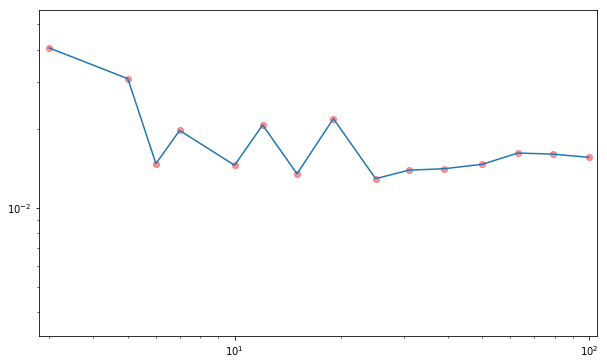

In [44]:
plt.figure(figsize = (10, 6))
for i in range(rep):
    plt.scatter(m_range, losses[:, i], c='r', alpha = 0.4)
plt.plot(m_range, np.exp(np.mean(np.log(losses), axis = 1)))
plt.yscale('log')
plt.xscale('log')
plt.xlim((2.8, 105))
#plt.ylim((1e-6, 1))
plt.show()

Write batch train function, reduce d, "use fresh samples at each iteration", sampling at test time